<a href="https://colab.research.google.com/github/olyadboka/Pagination/blob/main/SignLanguage_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

In [61]:
# Set device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


In [62]:
# Load Sign Language MNIST dataset
train_df = pd.read_csv("sign_mnist_train.csv")
valid_df = pd.read_csv("sign_mnist_valid.csv")

print(f"Training data shape: {train_df.shape}")
print(f"Validation data shape: {valid_df.shape}")

Training data shape: (27455, 785)
Validation data shape: (7172, 785)


In [63]:
# Display basic dataset information
print("=== Training Data Info ===")
train_df.info()
print("\n=== Validation Data Info ===")
valid_df.info()

=== Training Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB

=== Validation Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 43.0 MB


In [64]:
# Check for missing values
print("Missing values in training data:", train_df.isnull().sum().sum())
print("Missing values in validation data:", valid_df.isnull().sum().sum())

# Clean data by removing null values
train_df = train_df.dropna()
valid_df = valid_df.dropna()
print(f"\nCleaned training data shape: {train_df.shape}")
print(f"Cleaned validation data shape: {valid_df.shape}")

Missing values in training data: 0
Missing values in validation data: 0

Cleaned training data shape: (27455, 785)
Cleaned validation data shape: (7172, 785)


In [65]:
# Define constants for the model
IMG_HEIGHT = 28
IMG_WIDTH = 28
IMG_CHS = 1  # Grayscale images
N_CLASSES = 24  # Letters A-Z excluding J and Z
BATCH_SIZE = 32
EPOCHS = 20

In [66]:
class SignLanguageDataset(Dataset):
    """Custom Dataset for Sign Language MNIST"""

    def __init__(self, dataframe):
        self.dataframe = dataframe.copy()
        self.labels = self.dataframe['label'].values
        self.images = self.dataframe.iloc[:, 1:].values / 255.0  # Normalize to [0,1]
        self.images = self.images.reshape(-1, IMG_CHS, IMG_HEIGHT, IMG_WIDTH)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = torch.FloatTensor(self.images[idx])
        label = torch.LongTensor([self.labels[idx]])
        return image, label.squeeze()

In [67]:
# Create training and validation datasets
train_dataset = SignLanguageDataset(train_df)
valid_dataset = SignLanguageDataset(valid_df)

print(f"Training dataset: {len(train_dataset)} samples")
print(f"Validation dataset: {len(valid_dataset)} samples")

Training dataset: 27455 samples
Validation dataset: 7172 samples


In [68]:
# Create DataLoaders for efficient batch processing
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(valid_loader)}")

Training batches: 858
Validation batches: 225


In [69]:
# Verify data loading
sample_batch = next(iter(train_loader))
images, labels = sample_batch
print(f"Batch image shape: {images.shape}")
print(f"Batch label shape: {labels.shape}")
print(f"Sample labels: {labels[:10].numpy()}")

Batch image shape: torch.Size([32, 1, 28, 28])
Batch label shape: torch.Size([32])
Sample labels: [ 3  3 19  5 12  1  5 10  5  5]


In [70]:
class SignLanguageCNN(nn.Module):
    """CNN Model for Sign Language Recognition"""

    def __init__(self):
        super(SignLanguageCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            # First convolution block
            nn.Conv2d(IMG_CHS, 25, kernel_size=3, padding=1),
            nn.BatchNorm2d(25),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Second convolution block
            nn.Conv2d(25, 50, kernel_size=3, padding=1),
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),

            # Third convolution block
            nn.Conv2d(50, 75, kernel_size=3, padding=1),
            nn.BatchNorm2d(75),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(75 * 3 * 3, 512),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(512, N_CLASSES)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [71]:
# Create and initialize model
model = SignLanguageCNN().to(device)

# Print model summary
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

SignLanguageCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(25, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(50, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=675, out_features=51

In [72]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Loss function: CrossEntropyLoss")
print("Optimizer: Adam (lr=0.001)")

Loss function: CrossEntropyLoss
Optimizer: Adam (lr=0.001)


In [73]:
def calculate_accuracy(outputs, labels):
    """Calculate accuracy for a batch"""
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return correct, total

In [74]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train model for one epoch"""
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch_idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate metrics
        total_loss += loss.item() * images.size(0)
        correct, total = calculate_accuracy(outputs, labels)
        total_correct += correct
        total_samples += total

    epoch_loss = total_loss / total_samples
    epoch_acc = total_correct / total_samples

    return epoch_loss, epoch_acc

In [75]:
def validate(model, dataloader, criterion, device):
    """Validate model performance"""
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            correct, total = calculate_accuracy(outputs, labels)
            total_correct += correct
            total_samples += total

            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = total_loss / total_samples
    epoch_acc = total_correct / total_samples

    return epoch_loss, epoch_acc, all_predictions, all_labels

In [76]:
# Initialize lists to store metrics
train_losses, train_accs = [], []
valid_losses, valid_accs = [], []

print("Starting training...")
print("=" * 50)

for epoch in range(EPOCHS):
    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    valid_loss, valid_acc, _, _ = validate(model, valid_loader, criterion, device)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    # Print progress
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")
    print("-" * 40)

Starting training...
Epoch 1/20
Train Loss: 0.2967, Train Acc: 0.9143
Valid Loss: 0.0860, Valid Acc: 0.9688
----------------------------------------
Epoch 2/20
Train Loss: 0.0190, Train Acc: 0.9954
Valid Loss: 0.0700, Valid Acc: 0.9763
----------------------------------------
Epoch 3/20
Train Loss: 0.0133, Train Acc: 0.9962
Valid Loss: 0.1190, Valid Acc: 0.9692
----------------------------------------
Epoch 4/20
Train Loss: 0.0124, Train Acc: 0.9965
Valid Loss: 0.0782, Valid Acc: 0.9764
----------------------------------------
Epoch 5/20
Train Loss: 0.0133, Train Acc: 0.9961
Valid Loss: 0.1094, Valid Acc: 0.9709
----------------------------------------
Epoch 6/20
Train Loss: 0.0071, Train Acc: 0.9979
Valid Loss: 0.1919, Valid Acc: 0.9610
----------------------------------------
Epoch 7/20
Train Loss: 0.0104, Train Acc: 0.9969
Valid Loss: 0.1452, Valid Acc: 0.9628
----------------------------------------
Epoch 8/20
Train Loss: 0.0039, Train Acc: 0.9989
Valid Loss: 0.0626, Valid Acc: 0.9

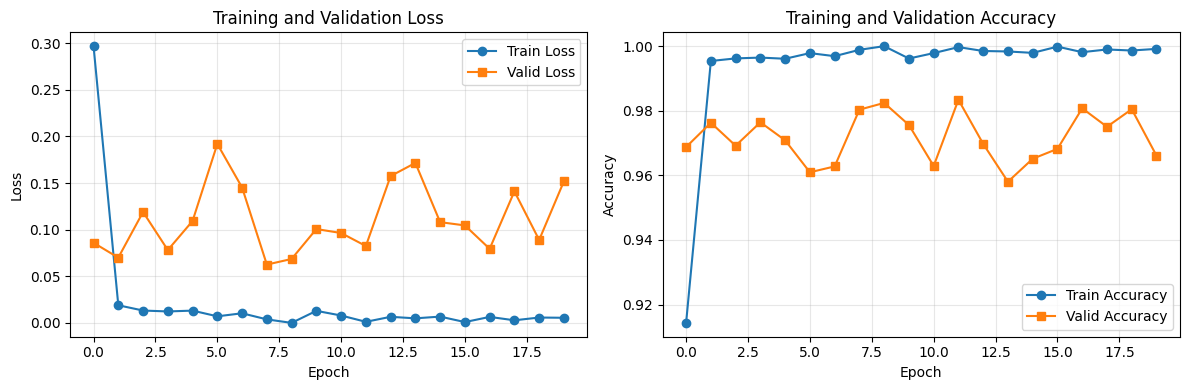

In [77]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
ax1.plot(train_losses, label='Train Loss', marker='o')
ax1.plot(valid_losses, label='Valid Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(train_accs, label='Train Accuracy', marker='o')
ax2.plot(valid_accs, label='Valid Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [78]:
# Final evaluation on validation set
print("FINAL EVALUATION")
print("=" * 50)

valid_loss, valid_acc, predictions, true_labels = validate(model, valid_loader, criterion, device)

print(f"Validation Loss: {valid_loss:.4f}")
print(f"Validation Accuracy: {valid_acc:.4f}")
print(f"Validation Accuracy: {valid_acc*100:.2f}%")

FINAL EVALUATION
Validation Loss: 0.1519
Validation Accuracy: 0.9661
Validation Accuracy: 96.61%


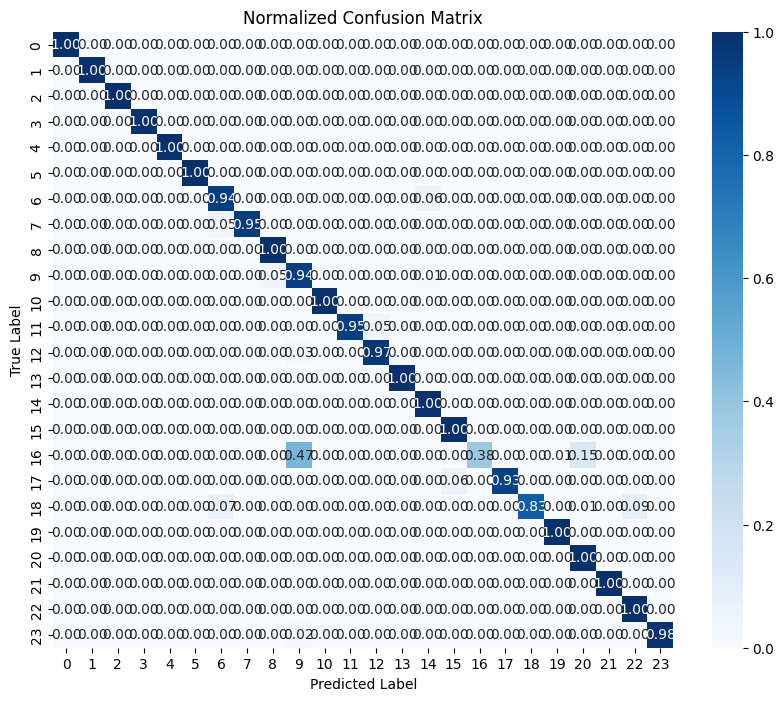

In [79]:
# Generate confusion matrix
cm = confusion_matrix(true_labels, predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=range(N_CLASSES),
            yticklabels=range(N_CLASSES))
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [80]:
# Generate classification report
print("CLASSIFICATION REPORT")
print("=" * 50)
report = classification_report(true_labels, predictions,
                               target_names=[f'Class_{i}' for i in range(N_CLASSES)])
print(report)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Class_0       1.00      1.00      1.00       331
     Class_1       1.00      1.00      1.00       432
     Class_2       1.00      1.00      1.00       310
     Class_3       1.00      1.00      1.00       245
     Class_4       1.00      1.00      1.00       498
     Class_5       1.00      1.00      1.00       247
     Class_6       0.90      0.94      0.92       348
     Class_7       1.00      0.95      0.98       436
     Class_8       0.95      1.00      0.97       288
     Class_9       0.79      0.94      0.86       331
    Class_10       1.00      1.00      1.00       209
    Class_11       1.00      0.95      0.97       394
    Class_12       0.93      0.97      0.95       291
    Class_13       1.00      1.00      1.00       246
    Class_14       0.94      1.00      0.97       347
    Class_15       0.92      1.00      0.96       164
    Class_16       1.00      0.38      0.55       144
    C

In [81]:
# Calculate additional metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print("ADDITIONAL METRICS")
print("=" * 50)
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")

ADDITIONAL METRICS
Weighted Precision: 0.9692
Weighted Recall: 0.9661
Weighted F1-Score: 0.9640


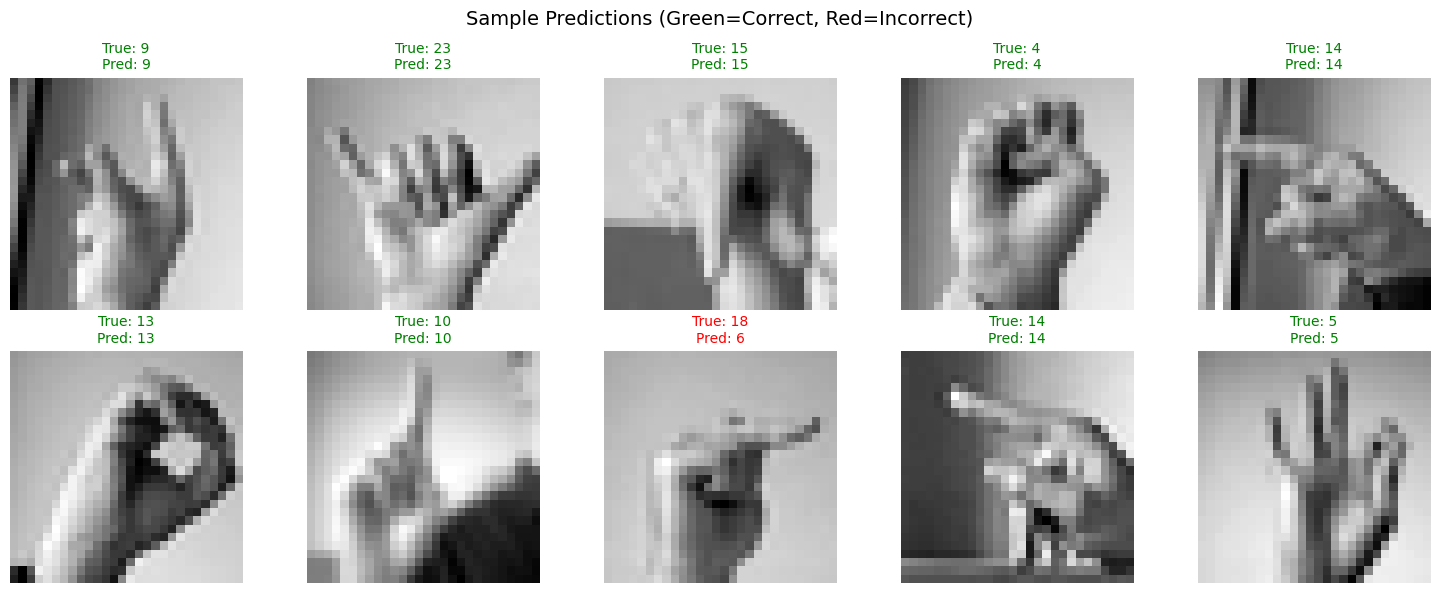

In [83]:
# Visualize sample predictions
def plot_sample_predictions(dataset, model, device, num_samples=10):
    model.eval()
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        image, true_label = dataset[idx]
        image = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image)
            _, predicted = torch.max(output, 1)

        image_np = image.squeeze().cpu().numpy()

        color = 'green' if predicted.item() == true_label else 'red'
        axes[i].imshow(image_np, cmap='gray') # Changed image_np[0] to image_np
        axes[i].set_title(f'True: {true_label}\nPred: {predicted.item()}',
                         color=color, fontsize=10)
        axes[i].axis('off')

    plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_sample_predictions(valid_dataset, model, device)

In [84]:
# Analyze misclassifications
misclassified_idx = np.where(np.array(predictions) != np.array(true_labels))[0]

if len(misclassified_idx) > 0:
    print(f"Number of misclassifications: {len(misclassified_idx)}")
    print(f"Misclassification rate: {len(misclassified_idx)/len(true_labels):.2%}")

    # Count misclassification pairs
    misclassification_pairs = {}
    for idx in misclassified_idx[:10]:  # Show first 10
        true = true_labels[idx]
        pred = predictions[idx]
        print(f"True: {true} → Predicted: {pred}")
else:
    print("No misclassifications found!")

Number of misclassifications: 243
Misclassification rate: 3.39%
True: 16 → Predicted: 9
True: 18 → Predicted: 6
True: 7 → Predicted: 6
True: 16 → Predicted: 20
True: 18 → Predicted: 22
True: 9 → Predicted: 8
True: 16 → Predicted: 9
True: 17 → Predicted: 15
True: 6 → Predicted: 14
True: 7 → Predicted: 6


In [85]:
# Create prediction function
def predict_sign_language(model, image_array):
    """Predict sign language from image array"""
    model.eval()

    # Preprocess image
    if len(image_array.shape) == 2:  # If (28, 28)
        image_array = image_array.reshape(1, 1, 28, 28)
    elif len(image_array.shape) == 3:  # If (1, 28, 28)
        image_array = image_array.reshape(1, 1, 28, 28)

    image_tensor = torch.FloatTensor(image_array).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

    return predicted.item(), confidence.item()

# Test prediction function
test_image, test_label = valid_dataset[0]
predicted_class, confidence = predict_sign_language(model, test_image.numpy())
print(f"Test image - True label: {test_label}, Predicted: {predicted_class}")
print(f"Confidence: {confidence:.2%}")

Test image - True label: 6, Predicted: 6
Confidence: 100.00%


In [86]:
# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'valid_losses': valid_losses,
    'train_accs': train_accs,
    'valid_accs': valid_accs,
    'final_accuracy': valid_acc,
}, 'sign_language_model_final.pth')

print("Model saved as 'sign_language_model_final.pth'")

Model saved as 'sign_language_model_final.pth'


In [87]:
# Test loading the saved model
loaded_checkpoint = torch.load('sign_language_model_final.pth',
                               map_location=device)

# Create new model instance
loaded_model = SignLanguageCNN().to(device)
loaded_model.load_state_dict(loaded_checkpoint['model_state_dict'])
loaded_model.eval()

# Test loaded model
test_loss, test_acc, _, _ = validate(loaded_model, valid_loader, criterion, device)
print(f"Loaded model validation accuracy: {test_acc:.4f}")
print(f"Loaded model validation accuracy: {test_acc*100:.2f}%")

Loaded model validation accuracy: 0.9661
Loaded model validation accuracy: 96.61%


In [88]:
# Create performance summary
print("PERFORMANCE SUMMARY")
print("=" * 60)
print(f"Model: SignLanguageCNN")
print(f"Dataset: Sign Language MNIST")
print(f"Classes: {N_CLASSES} (A-Z excluding J and Z)")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(valid_dataset)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Final Training Accuracy: {train_accs[-1]*100:.2f}%")
print(f"Final Validation Accuracy: {valid_accs[-1]*100:.2f}%")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1-Score: {f1:.4f}")

PERFORMANCE SUMMARY
Model: SignLanguageCNN
Dataset: Sign Language MNIST
Classes: 24 (A-Z excluding J and Z)
Training samples: 27455
Validation samples: 7172
Batch size: 32
Epochs: 20
Final Training Accuracy: 99.92%
Final Validation Accuracy: 96.61%
Validation Precision: 0.9692
Validation Recall: 0.9661
Validation F1-Score: 0.9640
